In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from copy import copy
import random

def pd_readcsv(filename):
    """
    Reads the pandas dataframe from a filename, given the index is correctly labelled
    """
    ans=pd.read_csv(filename)
    ans.index=pd.to_datetime(ans['DATETIME'])
    del ans['DATETIME']
    ans.index.name=None
    
    return ans

def log_return(data):
    """
    input: an price dataframe
    output: dataframe with log return
    """
    price = data['ADJ'].ffill()
    r = np.log(price) - np.log(price.shift(1))
    
    return r

In [2]:
import os

def get_code(directory):
    """
    get a list of instrument code from specified directory
    input: dir
    output: list
    """
    filelist = []
    
    # directory for Windows
    # directory = directory + '\\data'
    
    # directory for MacOS
    directory = directory + '/data'
    
    for filename in os.listdir(directory):
        if'_price.csv' in filename:
            filelist.append(filename)
    return filelist
        
directory = os.getcwd()
filelist = get_code(directory)

In [3]:
print(filelist)

['CORN_price.csv', 'SP500_price.csv', 'SOYBEAN_price.csv', 'PALLAD_price.csv', 'KOSPI_price.csv', 'BUND_price.csv', 'NASDAQ_price.csv', 'CAC_price.csv', 'KR10_price.csv', 'BOBL_price.csv', 'LEANHOG_price.csv', 'US20_price.csv', 'SHATZ_price.csv', 'BTP_price.csv', 'GBP_price.csv', 'COPPER_price.csv', 'MXP_price.csv', 'US2_price.csv', 'V2X_price.csv', 'OAT_price.csv', 'EUROSTX_price.csv', 'VIX_price.csv', 'CRUDE_W_price.csv', 'LIVECOW_price.csv', 'SMI_price.csv', 'US10_price.csv', 'AEX_price.csv', 'EUR_price.csv', 'PLAT_price.csv', 'GOLD_price.csv', 'EDOLLAR_price.csv', 'GAS_US_price.csv', 'KR3_price.csv', 'JPY_price.csv', 'US5_price.csv', 'NZD_price.csv', 'AUD_price.csv', 'WHEAT_price.csv']


# 1a. Historgram to check skew for single stock

CORN
SP500
SOYBEAN
PALLAD
KOSPI
BUND
NASDAQ
CAC
KR10
BOBL
LEANHOG
US20
SHATZ
BTP
GBP
COPPER
MXP
US2
V2X
OAT
EUROSTX
VIX
CRUDE_W
LIVECOW
SMI
US10
AEX
EUR
PLAT


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GOLD
EDOLLAR
GAS_US
KR3
JPY
US5
NZD
AUD
WHEAT


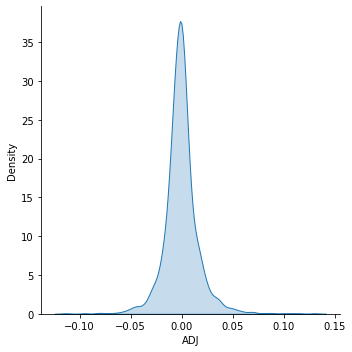

In [6]:
import seaborn as sns

log_returns_dict = {}
for stock in filelist:
    data = pd_readcsv('data/'+ stock)
    r = log_return(data)
    name = stock.replace('_price.csv','')
    #print(name)
    log_returns_dict[name] = r
    

sns.displot(log_returns_dict['VIX'], kind='kde', fill=True)

In [7]:
log_returns_dict['VIX'].skew()

0.6677037664816884

# 1b. Resampled skewness for all futures

In [12]:
def resampled_skew(data, niter=500):
    """
    resample the skew to lower estimate error
    """
    skew_distribution = []
    for i in range(niter):
        resample_index = [int(random.uniform(0,len(data))) for _ in range(len(data))] #resampe with replacement
        resample_data = data[resample_index]
        resample_skew = resample_data.skew()
        skew_distribution.append(resample_skew)
    return skew_distribution

In [13]:
skew_distribution_dict = {}
for file in filelist:
    try:
        name = file.replace('_price.csv','')
        abs_path = os.getcwd() + '/data/' + file
        #print(abs_path)
        data = pd_readcsv(abs_path)
        r = log_return(data)
        x = resampled_skew(r)
        y = pd.Series(x)
        skew_distribution_dict[name] = y
    except Exception as e:
        print(f"Error: {e}, at loading {name}")
        
    
df_skew_distribution = pd.DataFrame(skew_distribution_dict)
df_skew_distribution = df_skew_distribution.reindex(df_skew_distribution.mean().sort_values().index,axis=1)    

/Users/terry/spyder-workspace/data/CORN_price.csv
/Users/terry/spyder-workspace/data/SP500_price.csv
/Users/terry/spyder-workspace/data/SOYBEAN_price.csv
/Users/terry/spyder-workspace/data/PALLAD_price.csv
/Users/terry/spyder-workspace/data/KOSPI_price.csv
/Users/terry/spyder-workspace/data/BUND_price.csv
/Users/terry/spyder-workspace/data/NASDAQ_price.csv
/Users/terry/spyder-workspace/data/CAC_price.csv
/Users/terry/spyder-workspace/data/KR10_price.csv
/Users/terry/spyder-workspace/data/BOBL_price.csv
/Users/terry/spyder-workspace/data/LEANHOG_price.csv
/Users/terry/spyder-workspace/data/US20_price.csv
/Users/terry/spyder-workspace/data/SHATZ_price.csv
/Users/terry/spyder-workspace/data/BTP_price.csv
/Users/terry/spyder-workspace/data/GBP_price.csv
/Users/terry/spyder-workspace/data/COPPER_price.csv
/Users/terry/spyder-workspace/data/MXP_price.csv
/Users/terry/spyder-workspace/data/US2_price.csv
/Users/terry/spyder-workspace/data/V2X_price.csv
/Users/terry/spyder-workspace/data/OAT_pr

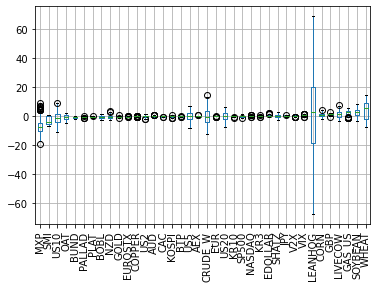

In [14]:
df_skew_distribution.boxplot()
plt.xticks(rotation=90)
plt.show()

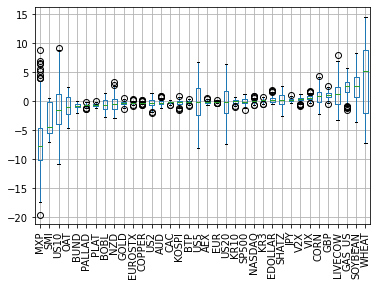

In [15]:
new_df = df_skew_distribution.drop(columns=['LEANHOG','CRUDE_W'])
new_df.boxplot()
plt.xticks(rotation=90)
plt.show()

# 2a. Bootstrapped expected return vs. skew

In [16]:
def resample_mean(data, niter=500):
    mean_est_distribution = []
    for _ in range(niter):
        resample_index = [int(random.uniform(0,len(data))) for _ in range(len(data))]
        resample_data = data[resample_index]
        mean_est = resample_data.mean()
        mean_est_distribution.append(mean_est)
        
    return mean_est_distribution

df_mean_distribution = {}
for file in filelist:
    try:
        name = file.replace('_price.csv','')
        #print(name)
        abs_path = os.getcwd() + '/data/' + file
        data = pd_readcsv(abs_path)
        r = log_return(data)
        x = resample_mean(r)
        y = pd.Series(x)
        df_mean_distribution[name] = y
    except Exception as e:
        print(f"Error: {e}, at loading {name}")
        

CORN
SP500
SOYBEAN


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


PALLAD
KOSPI
BUND
NASDAQ
CAC
KR10
BOBL
LEANHOG
US20
SHATZ
BTP
GBP
COPPER
MXP
US2
V2X
OAT
EUROSTX
VIX
CRUDE_W
LIVECOW
SMI
US10
AEX
EUR
PLAT
GOLD
EDOLLAR
GAS_US
KR3
JPY
US5
NZD
AUD
WHEAT


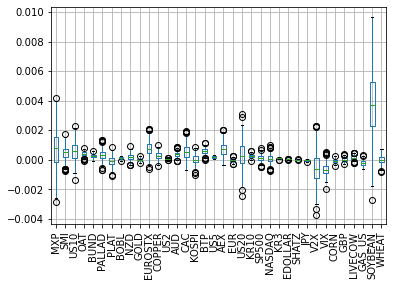

In [17]:
df_mean_distribution = pd.DataFrame(df_mean_distribution)
df_mean_distribution = df_mean_distribution[new_df.columns]
df_mean_distribution.boxplot()
plt.xticks(rotation=90)
plt.show()

## lump stocks into skews above average and below average

In [18]:
# calculate the mean skew for each security
skew_by_code = df_skew_distribution.mean()
# calculate the mean for all securities
avg_skew = np.mean(skew_by_code.values)
# find the stocks with lower/higher than avergage skew
low_skew_codes = list(skew_by_code[skew_by_code<avg_skew].index)
high_skew_codes = list(skew_by_code[skew_by_code>=avg_skew].index)


In [19]:
def resampled_mean_estimator_multiple_codes(returns, code_list, niter=500):
    mean_estimate_distribution = []
    for _ in range(niter):
        # randomly choose a stock in the given list       
        code = code_list[int(random.uniform(0, len(code_list)))]
        data = returns[code]
        # resample the return of that stock
        resample_index = [int(random.uniform(0,len(data))) for _ in range(len(data))]
        resampled_data = data[resample_index]
        sample_mean_estimate = resampled_data.mean()
        mean_estimate_distribution.append(sample_mean_estimate)

    return mean_estimate_distribution

df_mean_distribution_multiple = dict()
df_mean_distribution_multiple['High skew'] = resampled_mean_estimator_multiple_codes(log_returns_dict,high_skew_codes,1000)
df_mean_distribution_multiple['Low skew'] = resampled_mean_estimator_multiple_codes(log_returns_dict,low_skew_codes,1000)


(-0.001, 0.002)

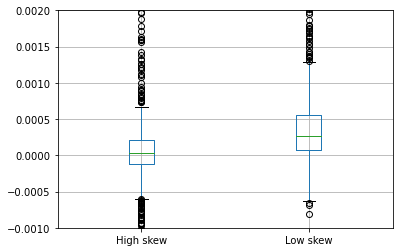

In [20]:
df_mean_distribution_multiple = pd.DataFrame(df_mean_distribution_multiple)
df_mean_distribution_multiple.boxplot()
plt.ylim(-0.001,0.002)

# 3a Assets with current negative skew outperform one with positive skew?

Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Division by 0
Divisi

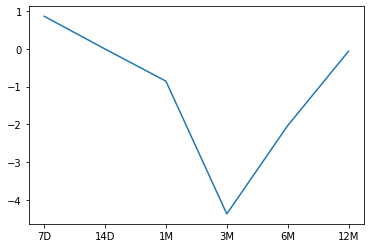

In [45]:
from scipy.stats import ttest_ind
all_SR_list = []
count = 0
loop = 0

# t-stat tells how likely there exists a difference, but it does not tell the magnitude
all_tstats=[]

# Define "current" with multiple time horizon
all_frequencies = ["7D", "14D", "1M", "3M", "6M", "12M"]

for freq in all_frequencies:
    all_results = []
    for name in log_returns_dict:
        
            # rolling windows            
            log_returns = log_returns_dict[name]
            start_date = log_returns_dict[name].index[0]
            end_date = log_returns_dict[name].index[-1]

            periodstarts = list(pd.date_range(start_date, end_date, freq=freq)) + [end_date]
            
            for periodidx in range(len(periodstarts) - 2):               
                p_start = periodstarts[periodidx]+pd.DateOffset(-1)
                p_end = periodstarts[periodidx+1]+pd.DateOffset(-1)
                s_start = periodstarts[periodidx+1]
                s_end = periodstarts[periodidx+2]

                period_skew = log_returns_dict[name][p_start:p_end].skew()
                subsequent_return = log_returns_dict[name][s_start:s_end].mean()
                subsequent_vol = log_returns_dict[name][s_start:s_end].std()
                
                # there are 118 ZeroDivisionError out of 57000 datapoints
                try:
                    subsequent_SR = 16*(subsequent_return / subsequent_vol)
                except ZeroDivisionError:
                    subsequent_SR = np.nan
                    #print("Division by 0")
                    

                if np.isnan(subsequent_SR) or np.isnan(period_skew):
                    continue                
                else:
                    all_results.append([period_skew, subsequent_SR])
                    
    all_results=pd.DataFrame(all_results, columns=['x', 'y'])
    avg_skew=all_results.x.median()
    all_results[all_results.x>avg_skew].y.median()
    all_results[all_results.x<avg_skew].y.median()

    subsequent_distribution = dict()
#     subsequent_distribution['High_skew'] = all_results[all_results.x>=avg_skew].y
#     subsequent_distribution['Low_skew'] = all_results[all_results.x<avg_skew].y
    subsequent_distribution['Pos_skew'] = all_results[all_results.x>=0].y
    subsequent_distribution['Neg_skew'] = all_results[all_results.x<0].y
    
    subsequent_distribution = pd.DataFrame(subsequent_distribution)

    med_SR =subsequent_sr_distribution.median()
#     tstat = ttest_ind(subsequent_distribution.High_skew, subsequent_distribution.Low_skew, nan_policy="omit").statistic
    tstat = ttest_ind(subsequent_distribution.Pos_skew, subsequent_distribution.Neg_skew, nan_policy="omit").statistic

    all_SR_list.append(med_SR)
    all_tstats.append(tstat)
    
all_tstats = pd.Series(all_tstats, index=all_frequencies)
all_tstats.plot(x="Frequency", y="t-statistics")

Text(0, 0.5, 't-statistics')

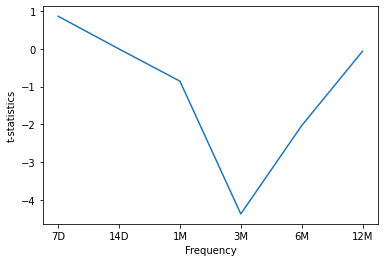

In [44]:
all_tstats.plot(x="Frequency", y="t-statistics")
# plt.title("t-stat for the null hypothesis that positive and negative skewness create same expected return")
plt.xlabel("Frequency")
plt.ylabel("t-statistics")